https://dash.harvard.edu/handle/1/42638988
https://www.medrxiv.org/content/10.1101/2020.03.09.20033357v1.full.pdf

# Recovery modeling

We will use the availavle data to model the recovery time.

The following assumptions are made:

## 1. Incubation Period:

The incubation period(I_period) is a Lognormal Distribution with mean equal to 5.6 days and standard deviation of 2.8.


Upon infection, the I_period will be sampled from this distribution.

When someone is infected, it takes I_period for them to become infectious. When someone has been infected for I_incubation days, we say that the we have the onset of the simptomns.

## 2. Onset to Hospitalization

Once someon start showing simptons, we say that the person takes H_period to be hospitalized. Here, we will model that this is the period where the person becomes infectious.

We are going to assume that in those infected, we have three groups: individuals who are
asymptomatic or have mild symptoms (95.6%), individuals who are hospitalized but do not
require critical care (3.08%), and individuals who are hospitalized and require critical care (1.32%). https://www.imperial.ac.uk/media/imperial-college/medicine/sph/ide/gida-fellowships/Imperial-College-COVID19-NPI-modelling-16-03-2020.pdf

We are going to assume that, after the H_period, a person will either be hospitalized or cured (recovered).

So in the general population, we will make the pessimistic estimation that someone infected has a 5% chance of needing hospitalization.

The H_period will be modeled as a gamma function.

If the person is either going to not need to be hospitalized or survive hospitalization, the H_period is equal to Gamma(mean=3.3, SD = 4.2).

However, if the person is going to die afterwards (here, the same as needing critical care), we have the H_period as Gamma(mean=6.5, SD = 4.0).

For both cases, we consider this to be the end of the infectiouness period.

## Hospitalization to outcome


https://careporthealth.com/wp-content/uploads/2020/04/COVID-19-Mortality-Report.pdf

The Mortality rates are assumed as following:

85+ -> 40%
65-84 -> 31%
55-64 -> 23%
45-54 -> 9%
20-44 -> 4%
0-19 -> 1%

With the distribution of hospitalizations among the age groups following:

85+ -> 8%
75-84 -> 15%
65-74 -> 20%
55-64 -> 21%
45-54 -> 15%
20-44 -> 19%
0-19  ->  2%

This way, we can average out the mortality rate of someone dying once it has been hospitalized as equal to: 35%

We were not able to find how long it takes for one patient to be cured, only for those addmited to die. So we will model both cases as follows:

Time from hospitalization to death equal to a Weibull distribution with mean equal to 8.9 days and standard deviation of 5.4

In [47]:
import numpy as np

mortality = {
            '85+' : 40,
            '65-84' : 31,
            '55-64' : 23,
            '45-54' : 9,
            '20-44' : 4,
            '0-19' : 1 
            }

distribution = {
    '85+' : 8,
    '65-84' : 35,
    '55-64' : 21,
    '45-54' : 15,
    '20-44' : 19,
    '0-19' : 2
}

np.mean(np.array(list(mortality.values())) * np.array(list(distribution.values())))/1000


0.3501666666666667

In [73]:
from scipy.special import gamma as gamma_func
from scipy.stats import weibull_min

In [503]:

def incubation_period(mean=None, sigma=None, log_mean=1.611195, log_sigma=0.47238):
    if mean and sigma:
        log_mean = np.log(mean) - .5*np.log(((sigma/mean)**2)+1)
        log_sigma = np.sqrt(np.log((sigma/mean)**2 + 1))
        
    return np.ceil(np.random.lognormal(mean=log_mean, sigma=log_sigma))

def needs_hospitalization(chance_of_hosp = 0.05):
    return np.random.random() < chance_of_hosp
    
def onset_to_hosp(mean_living = None, sigma_living = None,
                  mean_dead = None, sigma_dead = None,
                  shape_living=0.61735, scale_living=5.34545,
                  shape_dead=109.91155, scale_dead=0.05914,
                  survival_rate=.65, living = -1):
    
    if living == -1:
        living = np.random.random() < survival_rate
    
    if living:
        if mean_living and sigma_living:
            shape_living = (mean_living**2)/(sigma_living**2)
            scale_living = (sigma_living**2)/mean_living
        return np.ceil(np.random.gamma(shape_living, scale_living))
    
    else:
        if mean_dead and sigma_dead:
            shape_dead = (mean_dead**2)/(sigma_dead**2)
            scale_dead = (sigma_dead**2)/mean_dead
        return np.ceil(np.random.gamma(shape_living, scale_living))
        
def time_of_recovery(mean=None, sigma=None, shape=1.72051, scale=9.98274):
    if mean and sigma:
        shape = (sd/mean)**(-1.086)
        scale = mean/(gamma_func(1 + 1/shape))
        
    return np.ceil(weibull_min.rvs(c = shape, scale=scale))

    
def infection_timeline(day):
    timeline = {}
    timeline['infection_day'] = day
    timeline['end_of_incubation'] = day + incubation_period()
    timeline['contacts_infected'] = 0
    timeline['status'] = 'exposed'
    if needs_hospitalization():
        timeline['hospitalization'] = timeline['end_of_incubation'] + onset_to_hosp()
        timeline['removed'] = timeline['hospitalization'] + time_of_recovery()
    else:
        timeline['hospitalization'] = -1
        timeline['removed'] = timeline['end_of_incubation'] + onset_to_hosp(living=False)
    return timeline

In [504]:
def update_node_status(node, day):
    if node['infection_day'] != -1 and node['status'] != 'removed':
        if day >= node['end_of_incubation']:
            if node['hospitalization'] == -1:
                if day < node['removed']:
                    node['status'] = 'infected'
                else:
                    node['status'] = 'removed'
            elif day < node['hospitalization']:
                node['status'] = 'infected'
            elif day < node['removed']:
                node['status'] = 'hospitalized'
            else: 
                node['status'] = 'removed'

In [505]:
node = infection_timeline(0)
node['status'] = 'exposed'
print(node)
for i in range(1, 100):
    if node['status'] == 'removed': break
    update_node_status(node, i)
    print(f"{i}: {node['status']}")

{'infection_day': 0, 'end_of_incubation': 4.0, 'contacts_infected': 0, 'status': 'exposed', 'hospitalization': -1, 'removed': 5.0}
1: exposed
2: exposed
3: exposed
4: infected
5: removed


In [506]:
import os
os.chdir("../../")

import numpy as np
from src.visualization.graph_plot_utils import plot_graph, plot_infection
import collections, functools, operator 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [507]:
# Start with pct% of population infected
def init_graph(initial_infection = .05, graph_model = 'relaxed_caveman', pop_size = 1000):
    if graph_model == 'relaxed_caveman':
        G = nx.relaxed_caveman_graph(int(pop_size/4), 4, 0.25, seed=42)
    elif graph_model == 'scale_free':
        G = nx.scale_free_graph(pop_size)
    else:
        raise ValueError("Unknown graph type")
        
    init_infection(G, initial_infection)

    return G

def init_parameters(initial_infection, graph_model):
    G = init_graph(initial_infection, graph_model)
    
    status = current_status(G)
    
    pop = len(G.nodes)
    i = status['infected'] / pop
    s = (pop - i) / pop
    newly_infected = status['infected']
    r, contacts_infected = 0, 0

    data = [[s,i, r, newly_infected, contacts_infected]]

    return G, data, status, pop

def init_infection(G, pct):
    """
    Given a Graph G, infects pct% of population and set the remainder as susceptible.
    This is considered day 0.
    """
    size = int(len(G.nodes) * pct) 
    infected = np.random.choice(G.nodes, size = size)
    
    for node in G.nodes():
        if node in infected: 
            G.nodes[node].update(infection_timeline(0))
        else:
            G.nodes[node].update({'status': 'susceptible', 
                                  'infection_day' : -1, 
                                  'contacts_infected': 0})



def recover_one_step(G, day):
    """
    Recover everyone that has been infected recover_time days or more
    """

    for node, adjacencies in enumerate(G.adjacency()):
        update_node_status(G.nodes[node], day)


def spread_one_step(G, day, p_r = 0.5, lambda_leak = 0.05):
    """
    Spreads the infection 1 step, to the susceptible neighbours of infected people
    day is current day
    """
    newly_infected = []
       
    for node, adjacencies in enumerate(G.adjacency()):
        if G.nodes[node]['status'] == 'susceptible':
            if np.random.random() < lambda_leak:
                newly_infected.append(node)    
            else:
                for contact in adjacencies[1].keys():
                    if G.nodes[contact]['status'] == 'infected' and np.random.random() < p_r:
                            newly_infected.append(node)
                            G.nodes[contact]['contacts_infected'] += 1
                            break  
        
    for node in np.unique(newly_infected):
        G.nodes[node].update(infection_timeline(day))
        
    return len(newly_infected)


def simulate_one_step(G, day, recover_time=12, p_r=0.5, infectious_window=[4,6]):
    """
    Recover and Spread one step
    """
    recover_one_step(G, day, recover_time)
    newly_infected =  spread_one_step(G, day, p_r, infectious_window)
    return newly_infected

def current_status(G):
    """
    Returns a dict containing the current status of susceptible, infected and recovered
    """
    nodes = np.array(G.nodes(data=True))[:,1]
    result = collections.Counter(node['status'] for node in nodes)
    return result
    
    
def simulate_pandemic(initial_infection=.05, recover_time=12, p_r=.5, 
                          lambda_leak=.05, graph_model = 'relaxed_caveman'):
    """
    Runs the course of the pandemic from the start until
    less than 1% of the population is simultaneously infected or no one is infected
    """
    
    G, data, status, pop = init_parameters(initial_infection, graph_model)

    day = 0
    while (status['removed']+status['susceptible'])<pop:
        day +=1
        
        recover_one_step(G, day)
        
        newly_infected = spread_one_step(G, day, p_r, lambda_leak)
       
        status = current_status(G)
        i = status['infected'] / pop
        x = status['exposed'] / pop
        s = status['susceptible'] / pop
        r = status['removed'] / pop
        h = status['hospitalized'] / pop
        
        contacts_infected = [node['contacts_infected'] for i, node in G.nodes(data=True) if node['status'] == 'recovered']
        if len(contacts_infected) > 0: 
            contacts_infected = np.mean(contacts_infected)
        else:
            contacts_infected = np.nan
        data.append([s, i, x, r, h, newly_infected, contacts_infected])
    columns = ['susceptible', 'infected', 'exposed',
               'removed', 'hospitalized', 'newly_infected', 'contacts_infected_mean']

    time_series = pd.DataFrame(data, columns=columns)
    
    return time_series


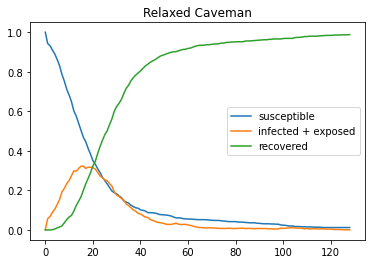

In [508]:
time_series = simulate_pandemic(p_r = 0.5, lambda_leak=.01)

plt.plot(time_series.index, time_series['susceptible'], label = 'susceptible')
plt.plot(time_series.index, time_series['infected'] + time_series['exposed'],
         label = 'infected + exposed')
plt.plot(time_series.index, time_series['removed'], label = 'recovered')
plt.legend()
plt.title('Relaxed Caveman')
plt.show()